# DB transformer

First set establish a postgres and install the dvdschema to it. This can be done using the following commands:

docker run --name some-postgres --rm -p 5432:5432 -e POSTGRES_HOST_AUTH_METHOD=trust -d postgres:12.15
    
docker exec some-postgres apt update -y

docker exec some-postgres apt install wget unzip -y

docker exec some-postgres wget https://www.postgresqltutorial.com/wp-content/uploads/2019/05/dvdrental.zip

docker exec some-postgres unzip dvdrental.zip

docker exec some-postgres psql -U postgres -c "CREATE DATABASE dvdrental;"

docker exec -i some-postgres pg_restore -U postgres -d dvdrental dvdrental.tar

docker exec some-postgres psql -U postgres -d dvdrental -c "create schema target;"


In [1]:
!apt update -y -q
!apt install build-essential libpq-dev graphviz graphviz-dev -y
!pip install psycopg2
!pip install eralchemy2
!pip install graphviz
!pip install openai

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Fetched 336 kB in 1s (295 kB/s)
Reading package lists...
Building dependency tree...
Reading state information...
42 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-3build2).
libgraphviz-dev is already the newest version (2.42.2-3build2).
build-essential is already the newest version (12.8ubuntu1.1).
libpq-dev is already the newest version (12.16-0ubuntu0.20.04.1).
0 upgraded, 0 newly installed, 0 to remove 

In [2]:
from eralchemy2 import render_er

## Draw from Postgres database
render_er("postgresql+psycopg2://postgres@0.0.0.0:5432/dvdrental", 'erd_from_postgres.png')


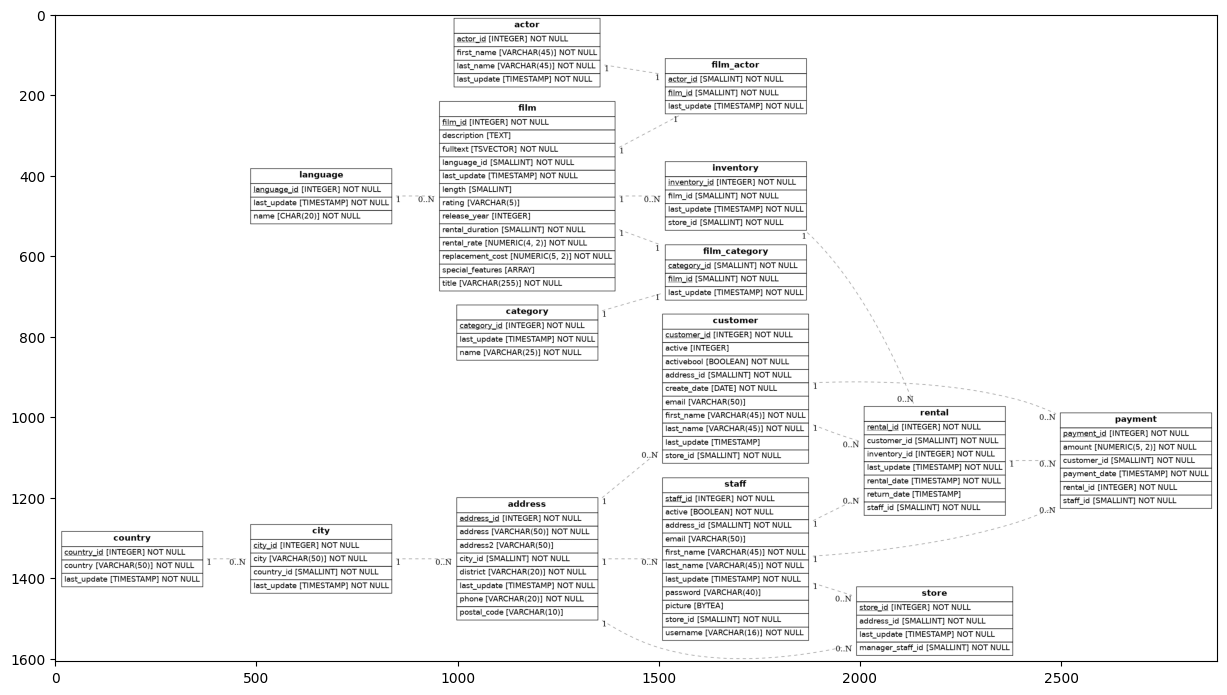

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = np.asarray(Image.open('erd_from_postgres.png'))
plt.rcParams["figure.figsize"] = (15, 10)
plt.imshow(img)
plt.show()


In [ ]:
conn.close()

In [4]:
import psycopg2
conn = psycopg2.connect("host=0.0.0.0 dbname=dvdrental user=postgres")
cur = conn.cursor()


In [5]:
from flask import request
import os
import openai
openai.api_key = os.getenv('YOUR_ENV_VAR')

In [6]:
def createweirdtarget01(targetschema='target',constraint=True):
    sql = "DROP SCHEMA IF EXISTS "+targetschema+" CASCADE;"
    try:
        cur.execute(sql)
    except Exception as err:
        print(err)
        er=err
    conn.commit()

    sql = "CREATE SCHEMA "+targetschema+";"
    try:
        cur.execute(sql)
    except Exception as err:
        print(err)
        er=err
    conn.commit()

    sql="CREATE TABLE target.movie (\
    m_id SERIAL PRIMARY KEY,\
    title TEXT NOT NULL,\
    category TEXT NOT NULL,\
    rental_date TIMESTAMP NOT NULL\
);"
    cur.execute(sql)
    if constraint:
        sql="CREATE TABLE target.info (\
            email TEXT NOT NULL,\
            address TEXT NOT NULL,\
            m_id INTEGER NOT NULL,\
            FOREIGN KEY (m_id) REFERENCES target.movie(m_id)\
        );"
    else:
        sql="CREATE TABLE target.info (\
            email TEXT NOT NULL,\
            address TEXT NOT NULL,\
            m_id INTEGER NOT NULL\
        );"        
    cur.execute(sql)
    conn.commit()
    sql="select a.address,b.email, e.title, c.rental_date, g.name from \
    public.address a, \
    public.customer b, \
    public.rental c, \
    public.inventory d, \
    public.film e, \
    public.film_category f, \
    public.category g \
    where \
    a.address_id=b.address_id and \
    b.customer_id=c.customer_id and \
    c.inventory_id=d.inventory_id and \
    d.film_id=e.film_id and \
    e.film_id=f.film_id and \
    f.category_id=g.category_id \
    order by name desc limit 10"
    cur.execute(sql)
    a=cur.fetchall()
    for i in range(10):
        sql="INSERT INTO target.movie (title, category, rental_date,m_id) VALUES ('"+a[i][2]+"','"+a[i][4]+"','"+a[i][3].strftime("%Y-%m-%d")+"','"+str(i)+"');"
        cur.execute(sql)
        conn.commit()
        sql="INSERT INTO target.info (email,address,m_id) VALUES ('"+a[i][1]+"','"+a[i][0]+"','"+str(i)+"');"
        cur.execute(sql)
        conn.commit()
        
        


In [75]:
def createweirdtarget02(targetschema='target',constraint=True,insertdata=True):
    sql = "DROP SCHEMA IF EXISTS "+targetschema+" CASCADE;"
    try:
        cur.execute(sql)
    except Exception as err:
        print(err)
        er=err
    conn.commit()

    sql = "CREATE SCHEMA "+targetschema+";"
    try:
        cur.execute(sql)
    except Exception as err:
        print(err)
        er=err
    conn.commit()

    sql="CREATE TABLE target.movie (\
    m_id SERIAL PRIMARY KEY,\
    title TEXT NOT NULL,\
    category TEXT NOT NULL,\
    language TEXT,\
    rental_date TIMESTAMP NOT NULL\
);"
    cur.execute(sql)
    if constraint:
        sql="CREATE TABLE target.info (\
            email TEXT NOT NULL,\
            address TEXT NOT NULL,\
            m_id INTEGER NOT NULL,\
            FOREIGN KEY (m_id) REFERENCES target.movie(m_id)\
        );"
    else:
        sql="CREATE TABLE target.info (\
            email TEXT NOT NULL,\
            address TEXT NOT NULL,\
            m_id INTEGER NOT NULL\
        );"        
    cur.execute(sql)
    conn.commit()
    sql="select a.address,b.email, e.title, c.rental_date, g.name, h.name as language from \
    public.address a, \
    public.customer b, \
    public.rental c, \
    public.inventory d, \
    public.film e, \
    public.film_category f, \
    public.category g, \
    public.language h \
    where \
    a.address_id=b.address_id and \
    b.customer_id=c.customer_id and \
    c.inventory_id=d.inventory_id and \
    d.film_id=e.film_id and \
    e.film_id=f.film_id and \
    f.category_id=g.category_id and \
    e.language_id=h.language_id \
    order by name desc limit 10"
    cur.execute(sql)
    a=cur.fetchall()
    if insertdata:
        for i in range(10):
            sql="INSERT INTO target.movie (title, category, rental_date,language, m_id) VALUES ('"+a[i][2]+"','"+a[i][4]+"','"+a[i][3].strftime("%Y-%m-%d")+"','"+a[i][5]+"','"+str(i)+"');"
            cur.execute(sql)
            conn.commit()
            sql="INSERT INTO target.info (email,address,m_id) VALUES ('"+a[i][1]+"','"+a[i][0]+"','"+str(i)+"');"
            cur.execute(sql)
            conn.commit()
        
        


In [62]:
createweirdtarget02(constraint=False)

In [9]:
import os
def givetabledef(schema,table):
    com="pg_dump -U postgres --schema-only -h 0.0.0.0 dvdrental -t '"+schema+"."+table+"' > dump.sql"
    os.system(com)
    flag=False
    with open('dump.sql', 'r') as f:
        lines = f.readlines()
    result=[]
    for line in lines:
        if ('CREATE' in line) or ('ALTER' in line):
            flag=True
        if flag:
            result.append(line)
        if flag and ';' in line:
            flag=False
    return result

In [10]:
def givetableconstraints(schema,table):
    com="pg_dump -U postgres --schema-only -h 0.0.0.0 dvdrental -t '"+schema+"."+table+"' > dump.sql"
    os.system(com)
    flag=False
    with open('dump.sql', 'r') as f:
        lines = f.readlines()
    result=[]
    for line in lines:
        if  ('ALTER' in line):
            flag=True
        if flag:
            result.append(line)
        if flag and ';' in line:
            flag=False
    return result

In [11]:
givetableconstraints('public','address')

['ALTER TABLE public.address OWNER TO postgres;\n',
 'ALTER TABLE ONLY public.address\n',
 '    ADD CONSTRAINT address_pkey PRIMARY KEY (address_id);\n',
 'ALTER TABLE ONLY public.address\n',
 '    ADD CONSTRAINT fk_address_city FOREIGN KEY (city_id) REFERENCES public.city(city_id);\n']

In [12]:
import random
import string

def generate_random_string(length):
    letters = string.ascii_letters
    return (''.join(random.choice(letters) for i in range(length))).lower()

random_string = generate_random_string(10)
print(random_string)


mkflvsnhjs


In [13]:
def getexampledata(schema,table,column="*"):
    sql="select "+column+" from "+schema+"."+table+" limit 10";
    #print(sql)
    cur.execute(sql)
    res=cur.fetchall()
    #print(res)
    results=[]
    for r in res:
        results.append(str(r[1:]))
    return(results)


In [14]:
getexampledata('public','address')

["('47 MySakila Drive', None, 'Alberta', 300, '', '', datetime.datetime(2006, 2, 15, 9, 45, 30))",
 "('28 MySQL Boulevard', None, 'QLD', 576, '', '', datetime.datetime(2006, 2, 15, 9, 45, 30))",
 "('23 Workhaven Lane', None, 'Alberta', 300, '', '14033335568', datetime.datetime(2006, 2, 15, 9, 45, 30))",
 "('1411 Lillydale Drive', None, 'QLD', 576, '', '6172235589', datetime.datetime(2006, 2, 15, 9, 45, 30))",
 "('1913 Hanoi Way', '', 'Nagasaki', 463, '35200', '28303384290', datetime.datetime(2006, 2, 15, 9, 45, 30))",
 "('1121 Loja Avenue', '', 'California', 449, '17886', '838635286649', datetime.datetime(2006, 2, 15, 9, 45, 30))",
 "('692 Joliet Street', '', 'Attika', 38, '83579', '448477190408', datetime.datetime(2006, 2, 15, 9, 45, 30))",
 "('1566 Inegl Manor', '', 'Mandalay', 349, '53561', '705814003527', datetime.datetime(2006, 2, 15, 9, 45, 30))",
 "('53 Idfu Parkway', '', 'Nantou', 361, '42399', '10655648674', datetime.datetime(2006, 2, 15, 9, 45, 30))",
 "('1795 Santiago de Com

In [15]:
def ddlemb(schema):
    #schema='public'
    sql="SELECT table_name FROM information_schema.tables WHERE table_schema = '"+schema+"' ORDER BY table_name;"
    cur.execute(sql)
    res=cur.fetchall()


    MODEL = "text-embedding-ada-002"

    #res
    #cosine = np.dot(A,B)/(norm(A)*norm(B))

    emb={}
    for a in res:
        #s=givetabledef(schema,a[0])
        s=givetableconstraints(schema,a[0])
        r = openai.Embedding.create(input=[''.join(s)], engine=MODEL)
        emb[a[0]]=r['data'][0]['embedding']
    return emb
    


sql="SELECT con.* \
FROM pg_catalog.pg_constraint con \
INNER JOIN pg_catalog.pg_class rel \
ON rel.oid = con.conrelid \
INNER JOIN pg_catalog.pg_namespace nsp \
ON nsp.oid = connamespace \
WHERE nsp.nspname = 'public' \
AND rel.relname = 'address';"

cur.execute(sql)
a=cur.fetchall()
a


In [16]:
givetabledef('public','address')

['CREATE TABLE public.address (\n',
 "    address_id integer DEFAULT nextval('public.address_address_id_seq'::regclass) NOT NULL,\n",
 '    address character varying(50) NOT NULL,\n',
 '    address2 character varying(50),\n',
 '    district character varying(20) NOT NULL,\n',
 '    city_id smallint NOT NULL,\n',
 '    postal_code character varying(10),\n',
 '    phone character varying(20) NOT NULL,\n',
 '    last_update timestamp without time zone DEFAULT now() NOT NULL\n',
 ');\n',
 'ALTER TABLE public.address OWNER TO postgres;\n',
 'ALTER TABLE ONLY public.address\n',
 '    ADD CONSTRAINT address_pkey PRIMARY KEY (address_id);\n',
 'CREATE INDEX idx_fk_city_id ON public.address USING btree (city_id);\n',
 'CREATE TRIGGER last_updated BEFORE UPDATE ON public.address FOR EACH ROW EXECUTE FUNCTION public.last_updated();\n',
 'ALTER TABLE ONLY public.address\n',
 '    ADD CONSTRAINT fk_address_city FOREIGN KEY (city_id) REFERENCES public.city(city_id);\n']

In [17]:
def columnemb_void(schema):
    emb={}
    MODEL = "text-embedding-ada-002"

    sql="SELECT table_name FROM information_schema.tables WHERE table_schema = '"+schema+"' ORDER BY table_name;"
    cur.execute(sql)
    rtable=cur.fetchall()

    for res_table in rtable:
        table=res_table[0]
        sql="SELECT column_name as cn FROM information_schema.columns WHERE table_schema = '"+schema+"' AND table_name = '"+table+"';"
        cur.execute(sql)
        res=cur.fetchall()
        for r in res:
            column=r[0]
            sql="select '"+r[0]+"' from "+schema+"."+table+" limit 10";
            cur.execute(sql)
            res1=cur.fetchall()
            s=""
            for rr in res1:
                s=s+str(rr[0])+"\n" 
            rrr = openai.Embedding.create(input=[''.join(s)], engine=MODEL)
            v=rrr['data'][0]['embedding']
            #v=89
            k={"schema":schema,"table":table,"column":column,"examples":s,"emb":v}
            key=schema+"|"+table+"|"+column.replace(" ","-")
            emb[key]=v
    return emb


In [18]:
import pandas as pd
def columnexampleembmatrix(schema):
    emb={}
    MODEL = "text-embedding-ada-002"

    sql="SELECT table_name FROM information_schema.tables WHERE table_schema = '"+schema+"' ORDER BY table_name;"
    cur.execute(sql)
    rtable=cur.fetchall()

    for res_table in rtable:
        table=res_table[0]
        sql="SELECT column_name as cn FROM information_schema.columns WHERE table_schema = '"+schema+"' AND table_name = '"+table+"';"
        cur.execute(sql)
        res=cur.fetchall()
        for r in res:
            column=r[0]
            #print(table + '|' + column)
            sql='select "'+r[0]+'" from '+schema+'.'+table+' limit 10;'
            #print(sql)
            cur.execute(sql)
            res1=cur.fetchall()
            w=[]
            for rr in res1:
                s=str(rr[0])
                #print(s)
                if (s is not None):
                    if s != '':
                        rrr = openai.Embedding.create(input=[s], engine=MODEL)
                        v=rrr['data'][0]['embedding']
                        w.append(v)
            if len(w)==10:
                keyname=schema+'|'+table+'|'+column
                emb[keyname]=pd.DataFrame(w)
    return emb

In [19]:
mtarget=columnexampleembmatrix('target')

In [20]:
mtarget

{'target|info|email':        0         1         2         3         4         5         6     \
 0  0.001913 -0.012135  0.006036 -0.041814 -0.021538  0.040749 -0.022378   
 1  0.009983 -0.016984  0.008249 -0.018149 -0.022728  0.028417 -0.020494   
 2  0.006690  0.000431 -0.007876 -0.023767 -0.025604  0.028387 -0.027747   
 3 -0.003330 -0.022583 -0.000302 -0.029243 -0.019232  0.025851 -0.020672   
 4 -0.000467 -0.015207 -0.016446 -0.022473 -0.015784  0.029936 -0.030245   
 5  0.002257 -0.014855  0.000264 -0.020884 -0.029203  0.020701 -0.014285   
 6 -0.002602 -0.002334  0.002250 -0.021775 -0.019004  0.012085 -0.013289   
 7  0.003372 -0.008310  0.002458 -0.023865 -0.033543  0.021030 -0.021500   
 8  0.001083 -0.011439  0.006282 -0.017679 -0.034183  0.032171 -0.039326   
 9  0.003710 -0.016687 -0.005613 -0.033867 -0.025585  0.033594 -0.041753   
 
        7         8         9     ...      1526      1527      1528      1529  \
 0 -0.010496 -0.008485 -0.015638  ...  0.010327 -0.017292  0

In [21]:
mpublic=columnexampleembmatrix('public')

In [22]:
def columncor(column_emb_source,column_emb_target):
    results=[]
    examples={}
    for k in column_emb_target.keys():
        targetschema=k.split("|")[0]
        targettable=k.split("|")[1]
        targetcolumn=k.split("|")[2]
        targetcolumn='"'+k.split("|")[2]+'"'
        
        sql='select '+targetcolumn +' from '+targetschema+'.'+targettable+' limit 10;'
        cur.execute(sql)
        res=cur.fetchall()
        conn.commit()
        examples[k]=[r[0] for r in res]

        #res=[]
        targetname=[]
        cor=[]
        for l in column_emb_source.keys():
            a=pd.DataFrame(column_emb_source[l])
            b=pd.DataFrame(column_emb_target[k])
            #print(k)
            #print(l)
            V=a.dot(b.transpose())
            v=V.mean().mean()
            targetname.append(l)
            sourceschema=l.split("|")[0]
            sourcetable=l.split("|")[1]
            #sourcecolumn="'"+l.split("|")[2]+"'"
            sourcecolumn='"'+l.split("|")[2]+'"'
            #sourceex=getexampledata(sourceschema,sourcetable,sourcecolumn)
            sql='select '+sourcecolumn +' from '+sourceschema+'.'+sourcetable+' limit 10;'
            cur.execute(sql)
            res=cur.fetchall()
            conn.commit()
            cor.append(v)
            examples[l]=[r[0] for r in res]
        df=pd.DataFrame({'target':targetname,'cor':cor})
        df=df.sort_values(by='cor',ascending=False)
        a={'target':k,'source':list(df['target'])}
        results.append(a)
    return results, [examples]

In [23]:
res,examples=columncor(mpublic,mtarget)

In [ ]:
res

In [24]:
def printcor(results,examples):
    for r in results:
        k=r['target']
        for l in r['source']:
            print("Target: {}, with examples {} \n has potential source {}\n with examples {}\n\n".format(k,examples[0][k][:3],l,examples[0][l][:3]))

In [25]:
printcor(res,examples)

Target: target|info|email, with examples ['monica.hicks@sakilacustomer.org', 'vincent.ralston@sakilacustomer.org', 'george.linton@sakilacustomer.org'] 
 has potential source public|customer|email
 with examples ['jared.ely@sakilacustomer.org', 'mary.smith@sakilacustomer.org', 'patricia.johnson@sakilacustomer.org']


Target: target|info|email, with examples ['monica.hicks@sakilacustomer.org', 'vincent.ralston@sakilacustomer.org', 'george.linton@sakilacustomer.org'] 
 has potential source public|customer_list|phone
 with examples ['28303384290', '838635286649', '448477190408']


Target: target|info|email, with examples ['monica.hicks@sakilacustomer.org', 'vincent.ralston@sakilacustomer.org', 'george.linton@sakilacustomer.org'] 
 has potential source public|customer|last_update
 with examples [datetime.datetime(2013, 5, 26, 14, 49, 45, 738000), datetime.datetime(2013, 5, 26, 14, 49, 45, 738000), datetime.datetime(2013, 5, 26, 14, 49, 45, 738000)]


Target: target|info|email, with examples

In [26]:
columnmaps={}
columnmaps['target.info.email']='public.customer.email'
columnmaps['target.info.address']='public.address.address'
#columnmaps['target|movie|title']='public|film|title'#skipping this one, very low on the list
columnmaps['target.movie.category']='public.category.name'
columnmaps['target.movie.rental_date']='public.rental.rental_date'#should also skip??


In [76]:
import re

class Prompt():
    def __init__(self,sourceschema,targetschema,targettable,columnmappings):
        self.sourcetables=[]
        self.sourceschema=sourceschema
        self.targetschema=targetschema
        self.targettable=targettable
        self.columnmappings=columnmappings
        self.messages=[]
        self.ddlemb=ddlemb(self.sourceschema)


    def initialmessage(self):
        prompt={
          "role": "system",
          "content": "Generate sql code in a separate message."
        }
        self.messages.append(prompt)

        prompt={
          "role": "user",
          "content": "You are a developer writing SQL queries. Given the following SQL tables and example data from them, your job is to write querie(s) that moves data from the schema"+self.sourceschema+ "to the "+self.targetschema+"."+self.targettable+" table. You might need to join tables in order to do so."     
        }
        self.messages.append(prompt)
        
        prompt={
        "role":"user",
        "content":"Table "+self.targetschema+"."+self.targettable+" has DDL:"
        }
        self.messages.append(prompt)
        s=givetabledef(self.targetschema,self.targettable)
        prompt={
        "role":"user",
        "content":''.join(s)
        }
        self.messages.append(prompt)            

        prompt={
          "role": "user",
          "content": "Also provide sql code to take data from the table "+self.targetschema+"."+self.targettable+" and put it back at its origin in the schema "+self.sourceschema
        }
        #self.messages.append(prompt)

        prompt={
          "role": "user",
          "content": "Please explain your reasoning."
        }
        self.messages.append(prompt)


    def addmappings(self):
        prompt={
          "role": "user",
          "content": "Mappings between some of the "+self.sourceschema+" columns and columns in "+self.targetschema+"."+self.targettable+" are:"
        } 
        for k in self.columnmappings.keys():
            targetschema=k.split(".")[0]
            targettable=k.split(".")[1]
            targetcolumn=k.split(".")[2]
            if targetschema==self.targetschema:
                if targettable==self.targettable:
                    prompt={
                      "role": "user",
                      "content": k+":"+self.columnmappings[k]
                    } 
                    self.messages.append(prompt)

    def addddl(self):
        for tab in self.sourcetables:
            prompt={
            "role":"user",
            "content":"Table "+self.sourceschema+"."+tab+" has DDL:"
            }
            self.messages.append(prompt)
            s=givetabledef(self.sourceschema,tab)
            prompt={
            "role":"user",
            "content":''.join(s)
            }
            self.messages.append(prompt)

            prompt={
            "role":"user",
            "content":"Some example data from this table is the following:"
            }
            #self.messages.append(prompt)
            s=getexampledata(self.sourceschema,tab,"*")
            for ss in s[:2]:
                prompt={"role":"user",
                       "content":ss}
                #self.messages.append(prompt)
                
    #def givetabledef(schema,table):

    def addsourcetables(self):
        if len(self.sourcetables)>0:
            for _ in range(2):
                B=pd.DataFrame(self.ddlemb)
                A=B[self.sourcetables]
                C=B[[k for k in self.ddlemb.keys() if k not in self.sourcetables]]
                V=C.transpose().dot(A)
                max_col = V.max().idxmax()
                max_row = V[max_col].idxmax()
                max_row = V.sum(axis=1).idxmax()
                self.sourcetables.append(max_row)
        if len(self.sourcetables)==0:
            for k in self.columnmappings.keys():
                #self.alreadythere=[self.ddlemb[k] ]
                l=self.columnmappings[k]
                sourceschema=l.split(".")[0]
                sourcetable=l.split(".")[1]
                sourcecolumn=l.split(".")[2]
                targetschema=k.split(".")[0]
                targettable=k.split(".")[1]
                targetcolumn=k.split(".")[2]
                if targettable==self.targettable:
                    self.sourcetables.append(sourcetable)
                    
    def getsql(self):
        r=openai.ChatCompletion.create(
          model="gpt-3.5-turbo-16k",
          #model="gpt-4",
          messages=self.messages
        )
        #print(self.messages)
        #print(r)
        text=r['choices'][0]['message']['content']
        match = re.search(r"sql\n([\s\S]*?)```\n", text) 
        sql = ""
        if match: 
            sql = match.group(1) 
        return(sql)
    
    def testsql(self,sql):
        createweirdtarget02(constraint=False,insertdata=False)
        try:
            cur.execute(sql)
        except Exception as err:
            conn.rollback()
            #print(err)
            er=str(err)
            return er
        conn.commit()
        return ""
    
    def buildsql(self):
        #print(self.messages)
        for j in range(8):
            self.messages=[]
            self.initialmessage()
            self.addmappings()
            self.addsourcetables()
            self.addddl()
            #print(len(self.messages))
            print(self.sourcetables)
            for i in range(2):
                sql=self.getsql()
                er=self.testsql(sql)
                #conn.close()
                #conn = psycopg2.connect("host=0.0.0.0 dbname=dvdrental user=postgres")
                #cur = conn.cursor()
                if er!="":
                    #try again, feedback error
                    prompt={"role":"user",
                   "content":"You answered with this sql:"}
                    self.messages.append(prompt)
                    prompt={"role":"user",
                   "content":sql}
                    self.messages.append(prompt)
                    print(sql)
                    print(er)
                    prompt={"role":"user",
                   "content":"Which unfortunately gave this error:"+er}
                    self.messages.append(prompt)
                    prompt={"role":"user",
                   "content":"Can you try again?"}
                    self.messages.append(prompt)
                else:
                    print("succes")
                    return sql
        return None
    


In [64]:
createweirdtarget02(constraint=False)

In [77]:
p=Prompt(sourceschema='public',targetschema='target',targettable='info',columnmappings=columnmaps)

In [78]:
r=p.buildsql()

['customer', 'address']
succes


In [79]:
from pprint import pprint
pprint(r)

('INSERT INTO target.info (email, address, m_id)\n'
 'SELECT c.email, a.address, c.customer_id\n'
 'FROM public.customer c\n'
 'JOIN public.address a ON c.address_id = a.address_id;\n')


In [68]:
createweirdtarget02(constraint=False)

In [83]:
p=Prompt(sourceschema='public',targetschema='target',targettable='movie',columnmappings=columnmaps)

In [84]:
r=p.buildsql()

['category', 'rental']
INSERT INTO target.movie (m_id, title, category, language, rental_date)
SELECT
    m.m_id,
    m.title,
    c.name,
    m.language,
    r.rental_date
FROM
    public.movie m
    JOIN public.category c ON m.category_id = c.category_id
    JOIN public.rental r ON m.rental_id = r.rental_id;

relation "public.movie" does not exist
LINE 9:     public.movie m
            ^


can't execute an empty query
['category', 'rental', 'film_category', 'city']
INSERT INTO target.movie (m_id, title, category, language, rental_date)
SELECT f.film_id, f.title, c.name, NULL, r.rental_date
FROM public.film f
JOIN public.film_category fc ON f.film_id = fc.film_id
JOIN public.category c ON fc.category_id = c.category_id
JOIN public.rental r ON f.film_id = r.inventory_id

duplicate key value violates unique constraint "movie_pkey"
DETAIL:  Key (m_id)=(1) already exists.

succes


In [85]:
from pprint import pprint
pprint(r)

('INSERT INTO target.movie (m_id, title, category, language, rental_date)\n'
 'SELECT DISTINCT ON (f.film_id)\n'
 '    f.film_id, f.title, c.name, NULL, r.rental_date\n'
 'FROM public.film f\n'
 'JOIN public.film_category fc ON f.film_id = fc.film_id\n'
 'JOIN public.category c ON fc.category_id = c.category_id\n'
 'JOIN public.rental r ON f.film_id = r.inventory_id\n'
 'ON CONFLICT DO NOTHING;\n')


In [82]:
from pprint import pprint
pprint(r)

('INSERT INTO target.movie (m_id, title, category, language, rental_date)\n'
 'SELECT\n'
 '    fc.film_id AS m_id,\n'
 '    f.title,\n'
 '    c.name AS category,\n'
 '    NULL AS language,\n'
 '    r.rental_date\n'
 'FROM\n'
 '    public.film_category fc\n'
 '    JOIN public.category c ON fc.category_id = c.category_id\n'
 '    JOIN public.film f ON fc.film_id = f.film_id\n'
 '    JOIN public.rental r ON r.rental_id = fc.film_id\n')


In [71]:
from pprint import pprint
pprint(r)

('INSERT INTO target.movie (m_id, title, category, language, rental_date)\n'
 'SELECT\n'
 '    f.film_id AS m_id,\n'
 '    f.title AS title,\n'
 '    c.name AS category,\n'
 '    l.name AS language,\n'
 '    r.rental_date AS rental_date\n'
 'FROM\n'
 '    public.film f\n'
 '    JOIN public.film_category fc ON f.film_id = fc.film_id\n'
 '    JOIN public.category c ON fc.category_id = c.category_id\n'
 '    JOIN public.language l ON f.language_id = l.language_id\n'
 '    JOIN public.film_actor fa ON f.film_id = fa.film_id\n'
 '    JOIN public.actor a ON fa.actor_id = a.actor_id\n'
 '    JOIN public.rental r ON f.film_id = r.inventory_id\n'
 '    JOIN public.inventory i ON r.inventory_id = i.inventory_id\n'
 '    JOIN public.store s ON i.store_id = s.store_id\n'
 '    JOIN public.address ad ON s.address_id = ad.address_id\n'
 '    JOIN public.city ct ON ad.city_id = ct.city_id\n'
 '    JOIN public.country cn ON ct.country_id = cn.country_id\n'
 'WHERE\n'
 "    cn.country = 'United States'

In [ ]:
p.messages

In [ ]:
r=openai.ChatCompletion.create(
  model="gpt-3.5-turbo-16k",
  #model="gpt-4",
  messages=p.messages
)
r


In [ ]:
text=r['choices'][0]['message']['content']
match = re.search(r"sql\n([\s\S]*?)```\n", text) 
sql = ""
if match: 
    sql = match.group(1) 


In [ ]:
sql

In [ ]:
pprint(sql)

In [ ]:
p.testsql(sql)